In [1]:
import torch 
import os
import re
import pandas as pd
import numpy as np
from itertools import permutations, product
from sklearn.metrics import f1_score
from tqdm import tqdm

import sys
sys.path.append('..')  
from src.utils.RawDataReader import RawDataReader
from src.utils.SingleHeadModel import SingleHeadModel

In [2]:
reader = RawDataReader()
true_labels = reader.get_labels()
datasets, means, stds = reader.get_normalised_dataset()

In [3]:
normalised_timestamp_loc = "1701450149.9963827"
models_dir = f"../models/{normalised_timestamp_loc}"

In [4]:
models = os.listdir(models_dir)

In [5]:
norm_file_pattern = re.compile(r'SingleHeadModel_norm_10hidden_r(\d+)_label(\d+)_fold(\d+).pth')

In [6]:
rs = []
labels = []
folds = []
for model in models:
    (r, label, fold) = norm_file_pattern.findall(model)[0]
    rs.append(int(r))
    labels.append(int(label))
    folds.append(int(fold))

In [7]:
models_df = pd.DataFrame({
    "r": rs,
    "labels": labels,
    "folds": folds
}).sort_values(["r","labels",'folds']).reset_index(drop=True)

In [8]:
models_df.head()

,r,labels,folds
0,1,0,0
1,1,0,1
2,1,0,2
3,1,0,3
4,1,0,4


In [9]:
models_df[["r"]].value_counts()

r
1    190
2    190
3    190
5    180
4    121
Name: count, dtype: int64

In [10]:
model_loc = lambda r, label, fold: f"{models_dir}/SingleHeadModel_norm_10hidden_r{r}_label{label}_fold{fold}.pth"

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:01<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../models/1701450149.9963827/SingleHeadModel_norm_10hidden_r4_label12_fold7.pth'

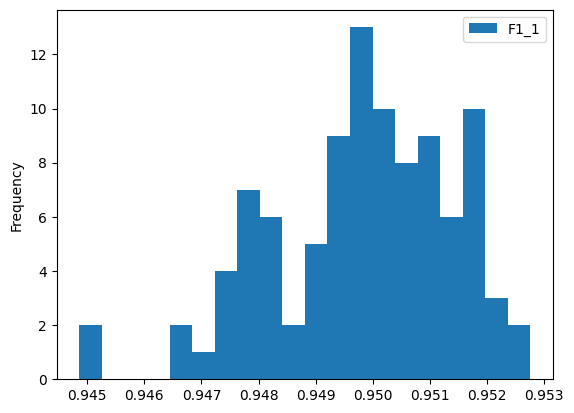

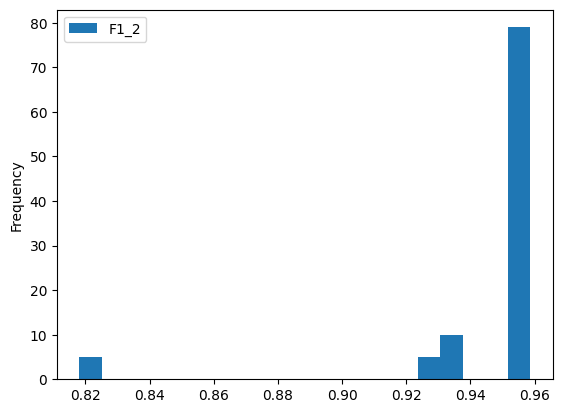

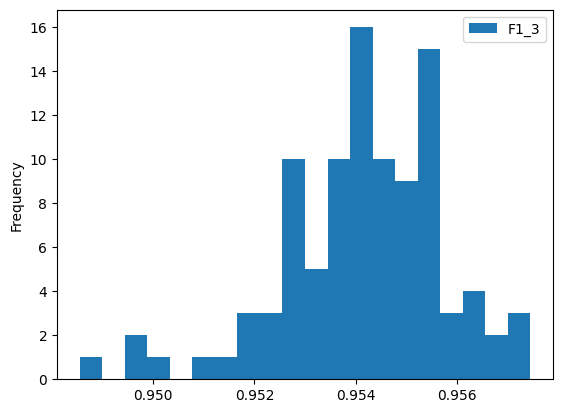

In [11]:
num_iterations = 99
hidden_layers = 10
samples = 20000


true_labels_int = true_labels.int()



for r in range(1, 6+1):
    feature_count = datasets[r].shape[1]
    dataset = datasets[r][:samples].to("cuda")
    f1_scores = []
    for _iter in tqdm(range(num_iterations)):
        fold = np.random.randint(0,10, size=19)
        prediction = []
        for label, fold in enumerate(fold):
            model_path = model_loc(r,label,fold)
            model = SingleHeadModel(feature_count=feature_count, hidden_count=hidden_layers)
            model.load_state_dict(torch.load(model_path))
            model.to("cuda")
            label_prediction = model(dataset)
            label_prediction.to("cpu")
            prediction.append(label_prediction)
            model.to("cpu")
            del model
            del label_prediction
            # torch.cuda.empty_cache()
        prediction = torch.cat(prediction, dim=1).to('cpu')
        prediction = (prediction > 0.5).float()
        f1 = f1_score(true_labels_int[:samples], prediction, average='micro')
        del prediction
        torch.cuda.empty_cache()
        f1_scores.append(f1)
    pd.DataFrame({
        f"F1_{r}": f1_scores
    }).plot.hist(bins=20)

<Axes: ylabel='Frequency'>

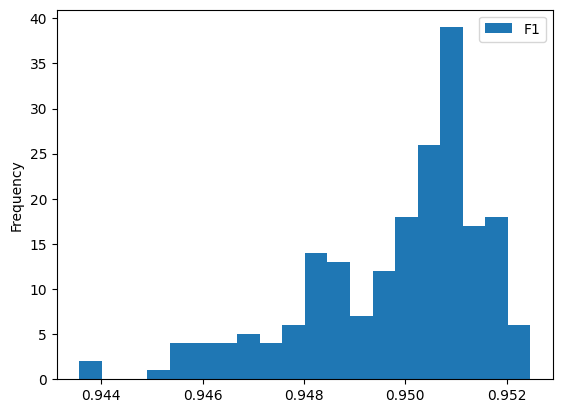

In [ ]:
pd.DataFrame({
    "F1": f1_scores
}).plot.hist(bins=20)

In [ ]:

torch.cuda.empty_cache()